In [16]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

# from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange 


In [17]:
import numpy as np
import pandas as pd

In [18]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [64]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [65]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [66]:
# reflect an existing database into a new model
Base = automap_base()


# automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [67]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [68]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [69]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [39]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

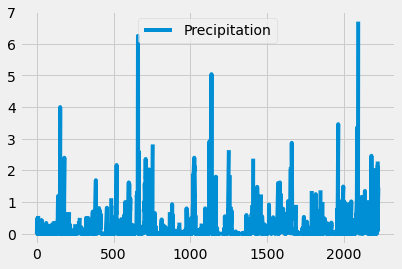

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# for row in session.query(Measurement, Measurement.date, Measurement.prcp).limit(330).all():
#     print(row)


target_date = dt.date(2017, 8, 23)
delta= dt.timedelta(days=365)
query_date = target_date - delta


h_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).order_by(Measurement.date.desc()).all()
h_prcp

h_prcp_df = pd.DataFrame(h_prcp, columns=['Date','Precipitation'])
h_prcp_df.head()
h_prcp_df.set_index('Date')

Year_prcp_df = h_prcp_df.sort_values(by='Date')
Year_prcp_df.head(10)
# h_prcp_df.sort_index(inplace=True)
# h_prcp_df.head(10)

# h_prcp_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
Year_prcp_df.plot(x_compat=True)

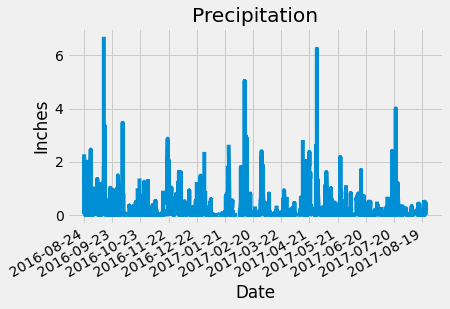

In [53]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt


Year_prcp_df = h_prcp_df.sort_values(by='Date')
Year_prcp_df.head(10)

dates = Year_prcp_df['Date']
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
y = Year_prcp_df["Precipitation"]


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation')
plt.tight_layout
plt.show()
plt.savefig('Precipitation.png')

plt.close()


In [27]:
Year_prcp_df = h_prcp_df.sort_values(by='Date')
Year_prcp_df.head(10)

,Date,Precipitation
2222,2016-08-24,1.45
2216,2016-08-24,0.08
2217,2016-08-24,2.15
2221,2016-08-24,2.15
2219,2016-08-24,NaN
2218,2016-08-24,2.28
2220,2016-08-24,1.22
2215,2016-08-25,0.11
2214,2016-08-25,0.06
2213,2016-08-25,0.21


In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Year_prcp_df.describe()


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [30]:
# Design a query to show how many stations are available in this dataset?
# s_id = session.query(Station, Station.id).all()
session.query(func.count(Station.id)).all()

[(9)]

In [40]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


active_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()
active_station
# active_station2 = session.query(Measurement.station).group_by(Measurement.station)\
#     .order_by(func.count(Measurement.station).desc()).all()
# active_station2
# active_station = session.query(Measurement.station, Measurement.date).join(Station, Measurement.station == Station.station).all()

# for record in active_station:
#     Measurement.station, Measurement.date = record
#     print("Station:", Measurement.station, "Date:", Measurement.date)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [42]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# session.query(Measurement.station, func.min(Measurement.tobs)).all()
# session.query(Measurement.station, func.max(Measurement.tobs)).all()
# session.query(Measurement.id, func.min(Measurement.tobs)).all()
# session.query('USC00519281', func.mean(Measurement.tobs)).all()
# 'USC00519281'
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
.filter(Measurement.station==active_station[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

In [57]:
active_station = session.query(Measurement.station, func.count(Measurement.tobs)).filter(Measurement.date>=query_date)\
        .group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
active_station

[('USC00519397', 366),
 ('USC00519281', 357),
 ('USC00516128', 354),
 ('USC00513117', 348),
 ('USC00519523', 342),
 ('USC00514830', 309),
 ('USC00517948', 185)]

In [43]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_temps = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc()).all()
active_temps
session.query(Measurement.station ==active_station[0][0], Measurement.date, Measurement.tobs).order_by(Measurement.date.desc()).all()


[(False, '2017-08-23', 81.0),
 (False, '2017-08-23', 82.0),
 (False, '2017-08-23', 82.0),
 (False, '2017-08-23', 76.0),
 (False, '2017-08-22', 82.0),
 (False, '2017-08-22', 82.0),
 (False, '2017-08-22', 76.0),
 (False, '2017-08-21', 81.0),
 (False, '2017-08-21', 79.0),
 (False, '2017-08-21', 82.0),
 (False, '2017-08-21', 76.0),
 (False, '2017-08-20', 81.0),
 (False, '2017-08-20', 80.0),
 (False, '2017-08-20', 78.0),
 (False, '2017-08-19', 79.0),
 (False, '2017-08-19', 80.0),
 (False, '2017-08-19', 85.0),
 (False, '2017-08-19', 71.0),
 (False, '2017-08-18', 80.0),
 (False, '2017-08-18', 77.0),
 (True, '2017-08-18', 79.0),
 (False, '2017-08-18', 76.0),
 (False, '2017-08-17', 78.0),
 (False, '2017-08-17', 83.0),
 (True, '2017-08-17', 76.0),
 (False, '2017-08-17', 72.0),
 (False, '2017-08-16', 82.0),
 (False, '2017-08-16', 79.0),
 (True, '2017-08-16', 76.0),
 (False, '2017-08-16', 71.0),
 (False, '2017-08-15', 78.0),
 (False, '2017-08-15', 82.0),
 (False, '2017-08-15', 79.0),
 (True, '2017

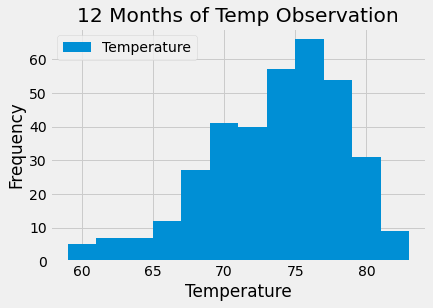

In [35]:
target_date = dt.date(2017, 8, 18)
delta= dt.timedelta(days=365)
query_date = target_date - delta

h_tob = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station=='USC00519281').\
    filter(Measurement.date > query_date).order_by(Measurement.date.desc()).all()
h_tob
h_tob_df = pd.DataFrame(h_tob, columns=['Date','Temperature'])
h_tob_df.head()

ax = h_tob_df.plot.hist(title="12 Months of Temp Observation", bins=12)
ax.set_xlabel('Temperature')
plt.tight_layout
plt.show()
plt.savefig('TempObservation.png')

plt.close()

## Bonus Challenge Assignment

In [81]:
start = (2016, 8, 13)
results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
        .group_by(Measurement.date)\
        .filter(Measurement.date>="2016-8-23").all()
# for i in results:
#     days = {
#         'TMAX' : func.max(Measurement.tobs),
#         'TMIN' : func.min(Measurement.tobs),
#         'TAVG' : func.avg(Measurement.tobs)
#     }
results

[(62.0, 74.0, 69.33333333333333),
 (66.0, 74.0, 69.2),
 (63.0, 73.0, 67.66666666666667),
 (62.0, 73.0, 67.16666666666667),
 (63.0, 72.0, 67.5),
 (62.0, 74.0, 67.66666666666667),
 (66.0, 72.0, 70.16666666666667),
 (60.0, 74.0, 67.66666666666667),
 (62.0, 77.0, 67.71428571428571),
 (62.0, 75.0, 66.71428571428571),
 (63.0, 78.0, 69.33333333333333),
 (65.0, 81.0, 69.16666666666667),
 (67.0, 75.0, 69.33333333333333),
 (65.0, 77.0, 71.0),
 (66.0, 78.0, 69.8),
 (67.0, 80.0, 72.33333333333333),
 (66.0, 75.0, 70.5),
 (72.0, 75.0, 73.28571428571429),
 (66.0, 78.0, 72.85714285714286),
 (67.0, 74.0, 71.0),
 (67.0, 74.0, 71.5),
 (68.0, 74.0, 71.2),
 (70.0, 77.0, 73.0),
 (67.0, 74.0, 70.33333333333333),
 (69.0, 73.0, 71.0),
 (67.0, 74.0, 71.14285714285714),
 (63.0, 74.0, 68.0),
 (64.0, 76.0, 68.0),
 (67.0, 73.0, 69.4),
 (66.0, 71.0, 68.42857142857143),
 (65.0, 70.0, 68.28571428571429),
 (62.0, 72.0, 68.0),
 (59.0, 72.0, 64.14285714285714),
 (60.0, 73.0, 66.0),
 (66.0, 76.0, 70.2),
 (69.0, 80.0, 74.5

In [89]:
start = "2016-8-23"
start = dt.datetime.strptime(start, "%Y-%m-%d")

results = session.query(Measurement.date, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
        .group_by(Measurement.date)\
        .filter(Measurement.date>=start).all()
#   * Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.
#   * When given the start only, calculate `TMIN`, `TAVG`, and `TMAX` for all dates greater than and equal to the start date.
#   * When given the start and the end date, calculate the `TMIN`, `TAVG`, and `TMAX` for dates between the start and end date inclusive.
    # print(results)
session.close()

temp_list = []

for i in results:
    start = {}
    start[i[0]] = {
        'TMAX' : i[2],
        'TMIN' : i[1],
        'TAVG' : i[3]
    }
    temp_list.append(start)
    
print(temp_list)

[{'2016-08-24': {'TMAX': 80.0, 'TMIN': 74.0, 'TAVG': 77.57142857142857}}, {'2016-08-25': {'TMAX': 81.0, 'TMIN': 77.0, 'TAVG': 79.42857142857143}}, {'2016-08-26': {'TMAX': 84.0, 'TMIN': 78.0, 'TAVG': 80.5}}, {'2016-08-27': {'TMAX': 81.0, 'TMIN': 73.0, 'TAVG': 76.83333333333333}}, {'2016-08-28': {'TMAX': 81.0, 'TMIN': 71.0, 'TAVG': 76.0}}, {'2016-08-29': {'TMAX': 80.0, 'TMIN': 78.0, 'TAVG': 78.71428571428571}}, {'2016-08-30': {'TMAX': 79.0, 'TMIN': 75.0, 'TAVG': 77.33333333333333}}, {'2016-08-31': {'TMAX': 80.0, 'TMIN': 76.0, 'TAVG': 78.28571428571429}}, {'2016-09-01': {'TMAX': 82.0, 'TMIN': 77.0, 'TAVG': 80.16666666666667}}, {'2016-09-02': {'TMAX': 81.0, 'TMIN': 75.0, 'TAVG': 79.42857142857143}}, {'2016-09-03': {'TMAX': 79.0, 'TMIN': 75.0, 'TAVG': 77.4}}, {'2016-09-04': {'TMAX': 84.0, 'TMIN': 73.0, 'TAVG': 77.0}}, {'2016-09-05': {'TMAX': 84.0, 'TMIN': 76.0, 'TAVG': 79.5}}, {'2016-09-06': {'TMAX': 80.0, 'TMIN': 73.0, 'TAVG': 75.66666666666667}}, {'2016-09-07': {'TMAX': 80.0, 'TMIN': 74.0

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
